In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # Must be before importing keras!
import sys
sys.path.insert(0,"/home/kal/CTCF/modules/")
sys.path.insert(0,"/home/kal/CTCF/mass_CTCF/modules/")
import tf_memory_limit
#import matplotlib; matplotlib.use('Agg')  # Must be before importing matplotlib.pyplot or before importing pylab!
from keras import backend as K
import tensorflow as tf
import numpy as np
import ctcfgen
import eval_convnet_ctcf
import ucscgenome
from convnet import Bias
from keras.models import load_model, Model
from keras.layers import Input, Activation
import viz_sequence
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy.signal import correlate2d
from sklearn.metrics import precision_recall_curve, roc_curve
from scipy.special import logit
import pysam
import matplotlib.pyplot as plt
import tqdm
import subprocess

motif_hits = '/home/kal/CTCF/mystery_seq/data/motif_hits.txt'
motif_bed = '/home/kal/CTCF/mystery_seq/data/motif_hits.bed'

TF_dir = '/home/kal/CTCF/mystery_seq/data/HumanTFs/'
out_dir = '/home/kal/CTCF/mystery_seq/data/intersect_HumanTFs/'

Using TensorFlow backend.


In [2]:
# load in peak regions
full_peaks = pd.read_table('/home/kal/data/raw_data/raw_chipseq.bed', header=None)
#full_peaks = pd.read_table('/home/kal/CTCF/mystery_seq/data/mystery_motif/motif_regions.bed', header=None)
full_peaks.columns = 'chr start end TF score num_exp exp_nums exp_scores'.split()

# load the sigmoid model
#model_path = '/home/kal/CTCF/mass_CTCF/output/sigmoid/20170919_150754/20170919_150754_weights_3_248_0.91.hdf5'
# or load the strength model
model_path = '/home/kal/CTCF/mass_CTCF/output/strength/20171128_132105/20171128_132105_weights_3_247_45227.62.hdf5'
model = load_model(model_path, custom_objects={'Bias':Bias})
layer_dict = dict([(layer.name, layer) for layer in model.layers])

get_act = K.function([model.input, K.learning_phase()], [layer_dict['bias'].output])

#load the genome
genome = ucscgenome.Genome('/home/kal/.ucscgenome/hg19.2bit')

In [3]:
def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

In [4]:
# get a subset of the encode dataset
peaks = full_peaks[full_peaks['TF'] == 'CTCF'].sample(100000)
peaks = peaks.append(full_peaks[full_peaks['TF'] != 'CTCF'].sample(100000))

In [5]:
# add annotations to the peaks
count = 0
for index, row in peaks.iterrows():
    count = count + 1
    # get the sequence
    center = (row.start + row.end) // 2
    if center < 128:
        center = 128
    seq = ctcfgen.encode(np.fromstring(genome[row.chr][center-128:center+128].lower(), dtype=np.uint8))
    
    # add the model score
    peaks.set_value(index,'ml_score', get_act([np.asarray([seq]*32),0])[0][0])

    # add the ctcf pwm score
    score, pwm, cmeme, cmeme_index, cposition = ctcfgen.get_pwm([seq], get_everything=True)
    peaks.set_value(index,'ctcf', score)
    peaks.set_value(index,'ctcf_orentation', (cmeme_index>1))
    peaks.set_value(index,'ctcf_position', cposition)

    
    # add the mystery pwm score
    score, pwm, mmeme, mmeme_index, mposition = ctcfgen.get_pwm([seq], get_everything=True, meme_library='mystery_memes')
    peaks.set_value(index,'mystery', score)
    peaks.set_value(index,'mystery_orentation', (mmeme_index>0))
    peaks.set_value(index,'mystery_position', mposition)
    if count % 1000 == 0:
        print('%.2f' % (count / 100000 * 100) + ' %')
        
    #distance/orentation calculation
    mcenter = mposition + mmeme.shape[0]/2 
    distance = mcenter - (cposition + cmeme.shape[0]/2)
    if (cmeme_index<2):
        #ctcf forward
        peaks.set_value(index,'distance', distance)
        if (mmeme_index < 1):
            # mystery forward
            peaks.set_value(index, 'omatch', 0) #match
        else:
            peaks.set_value(index, 'omatch', 1) #opposite        
    else:
        # ctcf reversed
        peaks.set_value(index,'distance', -distance)
        if (mmeme_index < 1):
            # mystery forward
            peaks.set_value(index, 'omatch', 1) #opposite
        else:
            peaks.set_value(index, 'omatch', 0) #match 
    
peaks['old_distance'] = peaks['mystery_position'] - peaks['ctcf_position']

1.00 %
2.00 %
3.00 %
4.00 %
5.00 %
6.00 %
7.00 %
8.00 %
9.00 %
10.00 %
11.00 %
12.00 %
13.00 %
14.00 %
15.00 %
16.00 %
17.00 %
18.00 %
19.00 %
20.00 %
21.00 %
22.00 %
23.00 %
24.00 %
25.00 %
26.00 %
27.00 %
28.00 %
29.00 %
30.00 %
31.00 %
32.00 %
33.00 %
34.00 %
35.00 %
36.00 %
37.00 %
38.00 %
39.00 %
40.00 %
41.00 %
42.00 %
43.00 %
44.00 %
45.00 %
46.00 %
47.00 %
48.00 %
49.00 %
50.00 %
51.00 %
52.00 %
53.00 %
54.00 %
55.00 %
56.00 %
57.00 %
58.00 %
59.00 %
60.00 %
61.00 %
62.00 %
63.00 %
64.00 %
65.00 %
66.00 %
67.00 %
68.00 %
69.00 %
70.00 %
71.00 %
72.00 %
73.00 %
74.00 %
75.00 %
76.00 %
77.00 %
78.00 %
79.00 %
80.00 %
81.00 %
82.00 %
83.00 %
84.00 %
85.00 %
86.00 %
87.00 %
88.00 %
89.00 %
90.00 %
91.00 %
92.00 %
93.00 %
94.00 %
95.00 %
96.00 %
97.00 %
98.00 %
99.00 %
100.00 %
101.00 %
102.00 %
103.00 %
104.00 %
105.00 %
106.00 %
107.00 %
108.00 %
109.00 %
110.00 %
111.00 %
112.00 %
113.00 %
114.00 %
115.00 %
116.00 %
117.00 %
118.00 %
119.00 %
120.00 %
121.00 %
122.00 %
123.00 %
1

In [6]:
# add orentation index
# 1: mystery first
# 2: convergent
# 3: ctcf first
# 4: divergent

for index, row in peaks.iterrows():
    if row['distance'] > 0:   
        # mystery upstream
        if (row['mystery_orentation'] < 1):
            # mystery aligned --> ctcf first
            peaks.set_value(index, 'orentation', 3)
        else:
            # mystery opposite --> converegent
                peaks.set_value(index, 'orentation', 2)
    else:
        # mystery downstream
        if (row['mystery_orentation'] < 1):
            # mystery aligned --> mystery first
            peaks.set_value(index, 'orentation', 1)
        else:
            # mystery opposite --> divergent
                peaks.set_value(index, 'orentation', 4)

In [ ]:
# old version
#for index, row in peaks.iterrows():
    # cases with mystery same direction as ctcf
#    if (row['mystery_orentation'] < 1) == (row['ctcf_orentation'] < 2):
#        if (row['mystery_orentation'] < 1) == (row['mystery_position'] > row['ctcf_position']):
            # mystery first
#            peaks.set_value(index, 'orentation', 1)
#        else:
            # ctcf first
#            peaks.set_value(index, 'orentation', 3)
    # cases with differing orentations
#    elif (row['mystery_orentation'] < 1) == (row['mystery_position'] < row['ctcf_position']):
        # convergent
#        peaks.set_value(index, 'orentation', 2)
#    else:
        # divergent
#        peaks.set_value(index, 'orentation', 4)

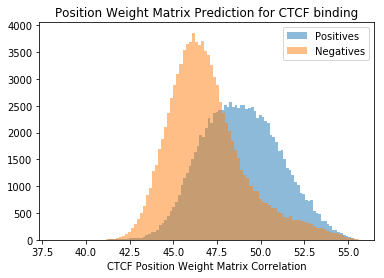

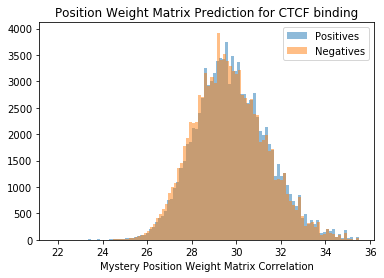

In [7]:
# get an idea of the score distribution
plt.hist(peaks[(peaks['TF'] == 'CTCF')]['ctcf'], 100, alpha=.5, label='Positives')
plt.hist(peaks[~(peaks['TF'] == 'CTCF')]['ctcf'], 100, alpha=.5, label='Negatives')
plt.title('Position Weight Matrix Prediction for CTCF binding')
plt.xlabel('CTCF Position Weight Matrix Correlation')
plt.legend()
plt.show()

plt.hist(peaks[(peaks['TF'] == 'CTCF')]['mystery'], 100, alpha=.5, label='Positives')
plt.hist(peaks[~(peaks['TF'] == 'CTCF')]['mystery'], 100, alpha=.5, label='Negatives')
plt.title('Position Weight Matrix Prediction for CTCF binding')
plt.xlabel('Mystery Position Weight Matrix Correlation')
plt.legend()
plt.show()

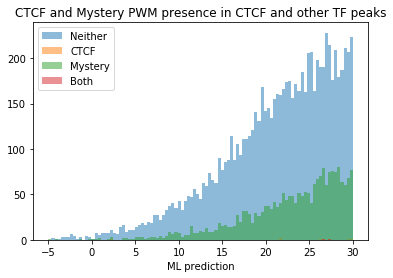

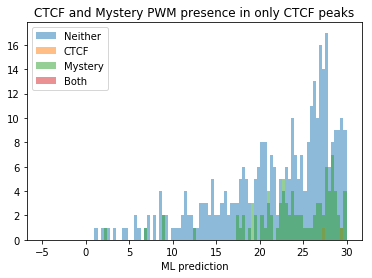

In [32]:
ctcf_cutoff = 50
mystery_cutoff = 30

# dead canadian plot
bins = np.linspace(-5, 30, 100)

#split the data
both = peaks[(peaks['ctcf'] > ctcf_cutoff) & (peaks['mystery'] > mystery_cutoff)]
ctcf_only = peaks[(peaks['ctcf'] > ctcf_cutoff) & (peaks['mystery'] < mystery_cutoff)]
mystery_only = peaks[(peaks['ctcf'] < ctcf_cutoff) & (peaks['mystery'] > mystery_cutoff)]
neither = peaks[(peaks['ctcf'] < ctcf_cutoff) & (peaks['mystery'] < mystery_cutoff)]

plt.hist(neither['ml_score'], alpha=0.5, bins=bins, label='Neither')
plt.hist(ctcf_only['ml_score'], alpha=0.5, bins=bins, label='CTCF')
plt.hist(mystery_only['ml_score'], alpha=0.5, bins=bins, label='Mystery')
plt.hist(both['ml_score'], alpha=0.5, bins=bins, label='Both')
plt.legend()
plt.title('CTCF and Mystery PWM presence in CTCF and other TF peaks')
plt.xlabel('ML prediction')
plt.show()

plt.hist(neither[(neither['TF'] == 'CTCF')]['ml_score'], alpha=0.5, bins=bins, label='Neither')
plt.hist(ctcf_only[(ctcf_only['TF'] == 'CTCF')]['ml_score'], alpha=0.5, bins=bins, label='CTCF')
plt.hist(mystery_only[(mystery_only['TF'] == 'CTCF')]['ml_score'], alpha=0.5, bins=bins, label='Mystery')
plt.hist(both[(both['TF'] == 'CTCF')]['ml_score'], alpha=0.5, bins=bins, label='Both')
plt.legend()
plt.title('CTCF and Mystery PWM presence in only CTCF peaks')
plt.xlabel('ML prediction')
plt.show()

For all data:


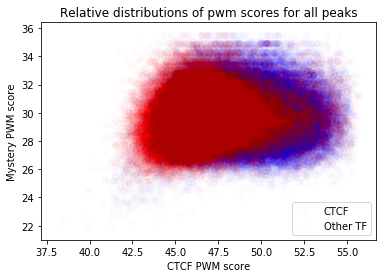

CTCF peaks: 0.000226540240964
Other TF peaks: 0.014843563384


In [9]:
print('For all data:')

#plot of score distributions
plt.scatter(peaks[(peaks['TF'] == 'CTCF')]['ctcf'],peaks[(peaks['TF'] == 'CTCF')]['mystery'], color='blue', alpha=0.01, label='CTCF')
plt.scatter(peaks[~(peaks['TF'] == 'CTCF')]['ctcf'],peaks[~(peaks['TF'] == 'CTCF')]['mystery'], color='red', alpha=0.01, label='Other TF')
plt.legend()
plt.xlabel('CTCF PWM score')
plt.ylabel('Mystery PWM score')
plt.title('Relative distributions of pwm scores for all peaks')
plt.show()

correlation = np.corrcoef(peaks[(peaks['TF'] == 'CTCF')]['ctcf'], peaks[(peaks['TF'] == 'CTCF')]['mystery'])[1,0]
rsq = correlation**2
print('CTCF peaks: ' + str(rsq))

correlation = np.corrcoef(peaks[~(peaks['TF'] == 'CTCF')]['ctcf'], peaks[~(peaks['TF'] == 'CTCF')]['mystery'])[1,0]
rsq = correlation**2
print('Other TF peaks: ' + str(rsq))

For peaks with two strong hits:


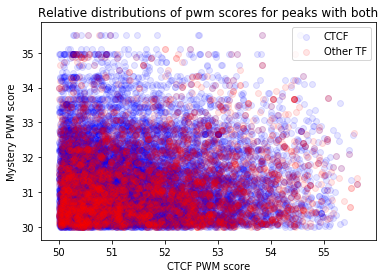

CTCF peaks: 0.00040071747631
Other TF peaks: 3.67000014201e-06


In [10]:
print('For peaks with two strong hits:')

#plot of score distributions
plt.scatter(both[(both['TF'] == 'CTCF')]['ctcf'], both[(both['TF'] == 'CTCF')]['mystery'], color='blue', alpha=0.1, label='CTCF')
plt.scatter(both[~(both['TF'] == 'CTCF')]['ctcf'], both[~(both['TF'] == 'CTCF')]['mystery'], color='red', alpha=0.1, label='Other TF')
plt.legend()
plt.xlabel('CTCF PWM score')
plt.ylabel('Mystery PWM score')
plt.title('Relative distributions of pwm scores for peaks with both')
plt.show()

correlation = np.corrcoef(both[(both['TF'] == 'CTCF')]['ctcf'], both[(both['TF'] == 'CTCF')]['mystery'])[1,0]
rsq = correlation**2
print('CTCF peaks: ' + str(rsq))

correlation = np.corrcoef((both[~(both['TF'] == 'CTCF')]['ctcf'], both[~(both['TF'] == 'CTCF')]['mystery']))[1,0]
rsq = correlation**2
print('Other TF peaks: ' + str(rsq))

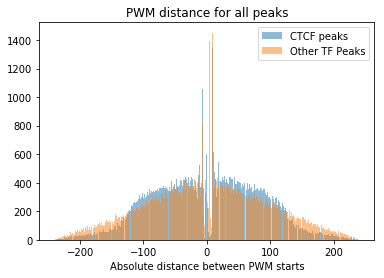

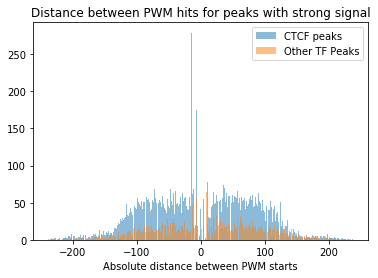

In [15]:
#make some dope plots of stuff
plt.hist(peaks[(peaks['TF'] == 'CTCF')]['distance'], 512, alpha=.5, label='CTCF peaks')
plt.hist(peaks[~(peaks['TF'] == 'CTCF')]['distance'], 512, alpha=.5, label='Other TF Peaks')
plt.legend()
plt.title('PWM distance for all peaks')
plt.xlabel('Absolute distance between PWM starts')
plt.show()

plt.hist(both[(both['TF'] == 'CTCF')]['distance'], 500, alpha=.5, label='CTCF peaks')
plt.hist(both[~(both['TF'] == 'CTCF')]['distance'], 500, alpha=.5, label='Other TF Peaks')
plt.legend()
plt.title('Distance between PWM hits for peaks with strong signal')
plt.xlabel('Absolute distance between PWM starts')
plt.show()

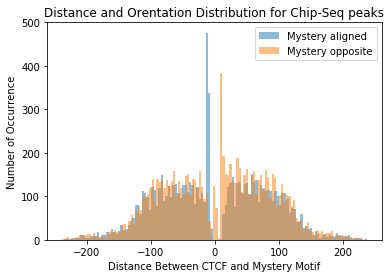

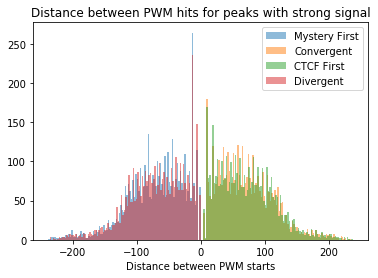

KeyError: 'full_distance'

In [33]:
# is the motif stronger when in the correct orentation?
plt.hist(both[(both['omatch'] == 0)]['distance'], bins = 128, alpha = 0.5, label = 'Mystery aligned')
plt.hist(both[(both['omatch'] == 1)]['distance'], bins = 128, alpha = 0.5, label = 'Mystery opposite')
plt.legend()
plt.ylabel('Number of Occurrence')
plt.xlabel('Distance Between CTCF and Mystery Motif')
plt.title('Distance and Orentation Distribution for Chip-Seq peaks')
plt.show()

plt.hist(both[(both['orentation'] == 1)]['distance'], bins = 100, alpha = 0.5, label = 'Mystery First')
plt.hist(both[(both['orentation'] == 2)]['distance'], bins = 100, alpha = 0.5, label = 'Convergent')
plt.hist(both[(both['orentation'] == 3)]['distance'], bins = 100, alpha = 0.5, label = 'CTCF First')
plt.hist(both[(both['orentation'] == 4)]['distance'], bins = 100, alpha = 0.5, label = 'Divergent')

plt.legend()
plt.title('Distance between PWM hits for peaks with strong signal')
plt.xlabel('Distance between PWM starts')
plt.show()

print('Mystery First ' + str(sum(both[(both['orentation'] == 1)]['full_distance'])/len(both[(both['orentation'] == 3)])))
print('Convergent ' + str(sum(both[(both['orentation'] == 2)]['full_distance'])/len(both[(both['orentation'] == 3)]['full_distance'])))
print('CTCF First ' + str(sum(both[(both['orentation'] == 3)]['full_distance'])/len(both[(both['orentation'] == 3)]['full_distance'])))
print('Divergent ' + str(sum(both[(both['orentation'] == 4)]['full_distance'])/len(both[(both['orentation'] == 3)]['full_distance'])))

both['full_distance'] = abs(both['mystery_position'] - both['ctcf_position'])

plt.hist(both[(both['orentation'] == 1)]['full_distance'], bins = 25, alpha = 0.5, label = 'Mystery First')
plt.hist(both[(both['orentation'] == 2)]['full_distance'], bins = 25, alpha = 0.5, label = 'Convergent')
plt.hist(both[(both['orentation'] == 3)]['full_distance'], bins = 25, alpha = 0.5, label = 'CTCF First')
plt.hist(both[(both['orentation'] == 4)]['full_distance'], bins = 25, alpha = 0.5, label = 'Divergent')

plt.legend()
plt.title('Distance between PWM hits for peaks with strong signal')
plt.xlabel('Absolute distance between PWM starts')
plt.show()

In [ ]:
plt.hist(both[(both['orentation'] == 1)]['true_distance'], bins = 50, alpha = 0.5, label = 'Mystery First')
plt.hist(both[(both['orentation'] == 2)]['true_distance'], bins = 50, alpha = 0.5, label = 'Convergent')
plt.hist(both[(both['orentation'] == 3)]['true_distance'], bins = 50, alpha = 0.5, label = 'CTCF First')
plt.hist(both[(both['orentation'] == 4)]['true_distance'], bins = 50, alpha = 0.5, label = 'Divergent')

plt.legend()
plt.title('Distance between PWM hits for peaks with strong signal')
plt.xlabel('Absolute distance between PWM starts')
plt.show()

plt.hist(both[(abs(both['orentation']-2.5) < 1)]['full_distance'], bins = 50, alpha = 0.5, label = 'Mystery Towards')
plt.hist(both[~(abs(both['orentation'] -2.5) < 1)]['full_distance'], bins = 50, alpha = 0.5, label = 'Mystery Away')

plt.legend()
plt.title('Distance between PWM hits for peaks with strong signal')
plt.xlabel('Absolute distance between PWM starts')
plt.show()

In [ ]:
#make some dope plots of stuff
plt.hexbin(peaks[(peaks['TF'] == 'CTCF')]['distance'], peaks[(peaks['TF'] == 'CTCF')]['mystery'] + peaks[(peaks['TF'] == 'CTCF')]['ctcf'], bins='log', label='CTCF peaks')
#plt.scatter(peaks[~(peaks['TF'] == 'CTCF')]['distance'],peaks[~(peaks['TF'] == 'CTCF')]['score'], alpha=.5, label='Other TF Peaks')
plt.legend()
plt.title('PWM distance for all CTCF peaks')
plt.xlabel('Absolute distance between PWM starts')
plt.ylabel('Aggregate PWM score')
plt.show()

plt.hexbin(both[(both['TF'] == 'CTCF')]['distance'], both[(both['TF'] == 'CTCF')]['ml_score'], bins='log', label='CTCF peaks')
#plt.hist(both[~(both['TF'] == 'CTCF')]['distance'], 50, alpha=.5, label='Other TF Peaks')
plt.legend()
plt.title('Distance between PWM hits for CTCF peaks with strong signal')
plt.xlabel('Absolute distance between PWM starts')
plt.ylabel('Chip-seq score')
plt.show()

In [ ]:
# plot the relative orentation frequencies 
plt.title('Frequencies or oreintaiton combinations')
plt.hist(peaks[(peaks['orentation'] == 1)]['ml_score'], bins = 50, alpha = 0.5, label = 'Mystery First')
plt.hist(peaks[(peaks['orentation'] == 2)]['ml_score'], bins = 50, alpha = 0.5, label = 'Convergent')
plt.hist(peaks[(peaks['orentation'] == 3)]['ml_score'], bins = 50, alpha = 0.5, label = 'CTCF First')
plt.hist(peaks[(peaks['orentation'] == 4)]['ml_score'], bins = 50, alpha = 0.5, label = 'Divergent')
plt.legend()
plt.xlabel('ML Score')
plt.show()

plt.title('Frequencies or oreintaiton combinations')
plt.hist(peaks[(peaks['orentation'] == 1)]['score'], bins = 50, alpha = 0.5, label = 'Mystery First')
plt.hist(peaks[(peaks['orentation'] == 2)]['score'], bins = 50, alpha = 0.5, label = 'Convergent')
plt.hist(peaks[(peaks['orentation'] == 3)]['score'], bins = 50, alpha = 0.5, label = 'CTCF First')
plt.hist(peaks[(peaks['orentation'] == 4)]['score'], bins = 50, alpha = 0.5, label = 'Divergent')
plt.legend()
plt.xlabel('Chip-Seq Score')
plt.show()

In [ ]:
# plot the relative orentation frequencies 
plt.title('Frequencies or oreintaiton combinations')
plt.hist(both[(both['orentation'] == 1)]['ml_score'], bins = 50, alpha = 0.5, label = 'Mystery First')
plt.hist(both[(both['orentation'] == 2)]['ml_score'], bins = 50, alpha = 0.5, label = 'Convergent')
plt.hist(both[(both['orentation'] == 3)]['ml_score'], bins = 50, alpha = 0.5, label = 'CTCF First')
plt.hist(both[(both['orentation'] == 4)]['ml_score'], bins = 50, alpha = 0.5, label = 'Divergent')
plt.legend()
plt.xlabel('ML Score')
plt.show()

plt.title('Frequencies or oreintaiton combinations')
plt.hist(both[(both['orentation'] == 1)]['score'], bins = 50, alpha = 0.5, label = 'Mystery First')
plt.hist(both[(both['orentation'] == 2)]['score'], bins = 50, alpha = 0.5, label = 'Convergent')
plt.hist(both[(both['orentation'] == 3)]['score'], bins = 50, alpha = 0.5, label = 'CTCF First')
plt.hist(both[(both['orentation'] == 4)]['score'], bins = 50, alpha = 0.5, label = 'Divergent')
plt.legend()
plt.xlabel('Chip-Seq Score')
plt.show()

In [ ]:
# annotate the encode data
mystery_memes = ctcfgen.process_meme('/home/kal/CTCF/mystery_seq/data/mystery_motif.meme')

preds = list()
ctcf_pwms = list()
mystery_pwms = list()

#add scores to regions
for index, row in peaks.iterrows():
    # get the sequence
    center = (row.start + row.end) // 2
    if center < 128:
        center = 128
    #print(row.chr + ' ' + str(center-128) + ':' + str(center+128))
    try:
        seq = ctcfgen.encode(np.fromstring(genome[row.chr][center-128:center+128].lower(), dtype=np.uint8))
        # get predictions
        pred = get_act([np.asarray([seq]*32),0])[0][0]
      
        # get scores    
        fseq, ctcf_score = ctcfgen.get_pwm([seq], get_score=True)
        fseq, mystery_score = ctcfgen.get_pwm([seq], get_score=True, meme_library=mystery_memes)  
    
        preds.append(pred)
        ctcf_pwms.append(ctcf_score)
        mystery_pwms.append(mystery_score)
        
    except ValueError:
        preds.append(np.NAN)
        ctcf_pwms.append(np.NAN)
        nearby_pwms.append(np.NAN)
        mystery_pwms.append(np.NAN)
        print(row.chr + ' ' + str(center-128) + ':' + str(center+128))
        
peaks['ctcf_pwm'] = np.asarray(ctcf_pwms)
peaks['mystery_pwm'] = np.asarray(mystery_pwms)
peaks['ml'] = np.asarray(preds)

In [ ]:
bins = np.linspace(10, 20, 100)

plt.hist(peaks[peaks['TF'] == 'CTCF']['mystery_pwm'], alpha=0.5, bins=bins, label='CTCF')
plt.hist(peaks[peaks['TF'] != 'CTCF']['mystery_pwm'], alpha=0.5, bins=bins, label='other TF')
plt.legend()
plt.title('Mystery Seq PWM scores in CTCF peaks')
plt.show()


bins = np.linspace(15, 30, 100)

plt.hist(peaks[peaks['TF'] == 'CTCF']['ctcf_pwm'], alpha=0.5, bins=bins, label='CTCF')
plt.hist(peaks[peaks['TF'] != 'CTCF']['ctcf_pwm'], alpha=0.5, bins=bins, label='other TF')
plt.legend()
plt.title('CTCF Seq PWM scores in CTCF peaks')
plt.show()

In [ ]:
bins = np.linspace(10, 20, 100)

plt.hist(peaks[peaks['ctcf_pwm'] > ctcf_cutoff]['mystery_pwm'], alpha=0.5, bins=bins, label='CTCF PWM hit')
plt.hist(peaks[peaks['ctcf_pwm'] < ctcf_cutoff]['mystery_pwm'], alpha=0.5, bins=bins, label='No PWM hit')
plt.legend()
plt.title('Mystery Seq PWM scores in TF peaks')
plt.xlabel('Mystery PWM score prediction')
plt.show()

bins = np.linspace(15, 30, 100)

plt.hist(peaks[peaks['mystery_pwm'] > mystery_cutoff]['ctcf_pwm'], alpha=0.5, bins=bins, label='Mystery PWM hit')
plt.hist(peaks[peaks['mystery_pwm'] < mystery_cutoff]['ctcf_pwm'], alpha=0.5, bins=bins, label='No PWM hit')
plt.legend()
plt.title('CTCF Seq PWM scores in TF peaks')
plt.xlabel('CTCF PWM score prediction')
plt.show()

In [ ]:
# plot vs transcription factors
TFs = list()
for TF in peaks['TF']:
    if TF not in TFs:
        TFs.append(TF)

plt.figure(figsize=(20,10))
        
for TF in TFs:
    average_ctcf = sum(peaks[peaks['TF'] == TF]['ctcf_pwm'])/len(peaks[peaks['TF'] == TF])
    average_mystery = sum(peaks[peaks['TF'] == TF]['mystery_pwm'])/len(peaks[peaks['TF'] == TF])
                                                                                                             
    plt.scatter(average_ctcf, average_mystery, label=TF)
    plt.annotate(TF, xy=(average_ctcf, average_mystery))
    
    
plt.xlabel('Average CTCF PWM score')
plt.ylabel('Average Mystery PWM score')
plt.title('Average PWM socres across TFs')
plt.show()

In [ ]:
# plot vs transcription factors
experiments = list()
listsolist = list()
for exp_list in peaks['exp_nums']:
    listsolist.append(exp_list)
    for num in exp_list.split(','):
        if num not in experiments:
            experiments.append(num)
            
peaks['exp_list'] = np.asarray(listsolist)
            
plt.figure(figsize=(20,10))
        
for experiment in experiments:
    average_ctcf = sum(peaks[experiment in peaks['exp_list']]['ctcf_pwm'])/len(peaks[experiment in peaks['exp_list']])
    average_mystery = sum(peaks[experiment in peaks['exp_nums'].split(',')]['mystery_pwm'])/len(peaks[experiment in peaks['exp_nums'].split(',')])
                                                                                                             
    plt.scatter(average_ctcf, average_mystery, label=experiment)
    plt.annotate(experiment, xy=(average_ctcf, average_mystery))
    
    
plt.xlabel('Average CTCF PWM score')
plt.ylabel('Average Mystery PWM score')
plt.title('Average PWM socres across experiments')
plt.show()

In [ ]:
# annotate with score information 
hit_info = hits.filter(['chr', 'start', 'end', 'sccore'])
hit_info.to_csv(motif_bed, sep='\t', header=None, index=False)

In [ ]:
# unzip TF files
for file in os.listdir(TF_dir):
    subprocess.run(['gunzip', os.path.join(TF_dir, file)])

In [ ]:
# generate intersection files
enrichment = dict()
for file in os.listdir(TF_dir):
    if '.bed' in file:
        print(file)
        new_file = os.path.join(out_dir, file.split('.bed')[0] + '.motif_intersect.bed')
        print(new_file)
        f = open(new_file, 'w')
        subprocess.run(['bedtools', 'intersect', '-a', motif_bed, '-b', os.path.join(TF_dir, file)], stdout=f)
        data = file.split('.')
        cell_line = data[0]
        TF = data[1]
        num_hits =  file_len(new_file)
        total = file_len(os.path.join(TF_dir, file))
        print(cell_line+'.'+TF+': ' +str(num_hits) + '/' + str(total))
        enrichment[cell_line+'.'+TF] = [num_hits, total]

In [ ]:
# read intersection files
enrichment = dict()
for new_file in os.listdir(out_dir):
    if '.bed' in new_file:
        data = new_file.split('.')
        cell_line = data[0]
        TF = data[1]
        num_hits =  file_len(os.path.join(out_dir, new_file))
        file = new_file.split('.motif_intersect.bed')[0] + '.bed'
        total = file_len(os.path.join(TF_dir, file))
        print(cell_line+'.'+TF+': ' +str(num_hits) + '/' + str(total))
        enrichment[cell_line+'.'+TF] = [num_hits, total]

In [ ]:
TFs = list()
for key in enrichment:
    if key.split('.')[1].split('-')[0] not in TFs:
        TFs.append(key.split('.')[1].split('-')[0])
               
for TF in TFs:
    print(TFcal)
    num_hits=list()
    total=list()
    for key in enrichment:
        if TF in key and ('CTCF' in key or enrichment[key][0]/enrichment[key][1] >.1):
            num_hits.append(enrichment[key][0])
            total.append(enrichment[key][1])
        plt.scatter(sum(num_hits), sum(total), label=TF)
      
plt.xlabel('Total number of peaks')
plt.ylabel('Number of intersecting peaks')
plt.title('Enrichment by TF')
plt.legend()
plt.show()

In [ ]:
TFs = list()
for key in enrichment:
    if key.split('.')[1].split('-')[0] not in TFs:
        TFs.append(key.split('.')[1].split('-')[0])
        
lines = list()
for key in enrichment:
    if key.split('.')[0] not in lines:
        lines.append(key.split('.')[0])
       
l = list()
t = list()
strength = list()
num_hits=list()
total=list()
for key in enrichment:
    this_TF = key.split('.')[1].split('-')[0]
    this_line = key.split('.')[0]
    l.append(this_line)
    t.append(this_TF)
    num_hits.append(enrichment[key][0])
    total.append(enrichment[key][1])
    strength.append(enrichment[key][0]/enrichment[key][1])
    
d = {'cell_line':l, 'TF':t, 'enrichment':strength, 'hits':num_hits, 'total':total}
df = pd.DataFrame(data=d)
print(df.head)

In [ ]:
#find total peaks
total = sum(df.hits)
heights = list()
labels = list()
for TF in df.TF:
    if TF not in labels:
        heights.append(sum(df[(df['TF'] == TF)].hits)/sum(df[(df['TF'] == TF)].total))
        labels.append(TF)
  
d={'TF':labels, 'hits':heights}
by_tf = pd.DataFrame(data=d)
plt.bar(range(len(by_tf)), by_tf.hits, tick_label=by_tf.TF)
plt.xticks(rotation=45)
plt.title('Motif hits by Transcription Factor')
plt.xlabel('Transcription Factor')
plt.ylabel('Number of Motif Hits')
plt.show()

d={'TF':labels, 'hits':heights}
by_tf = pd.DataFrame(data=d)
plt.bar(range(len(by_tf[(by_tf.hits>0.08)])), by_tf[(by_tf.hits>0.08)].hits, tick_label=by_tf[(by_tf.hits>0.08)].TF)
plt.xticks(rotation=45)
plt.title('Enrichment by Transcription Factor')
plt.xlabel('Transcription Factor')
plt.ylabel('Fraction of Motif Hits')
plt.show()

In [ ]:
#find total peaks
total = sum(df.hits)
heights = list()
enrichments = list()
labels = list()
ctcf_df = df
for line in ctcf_df.cell_line:
    if line not in labels:
        heights.append(sum((ctcf_df[ctcf_df['cell_line'] == line]).hits))
        enrichments.append(sum((ctcf_df[ctcf_df['cell_line'] == line]).hits)/sum((ctcf_df[ctcf_df['cell_line'] == line]).total))
        labels.append(line)
  
d={'line':labels, 'hits':heights}
by_l = pd.DataFrame(data=d)
plt.bar(range(len(by_l)), by_l.hits, tick_label=by_l.line)
plt.title('Motif hits by Cell Line')
plt.xlabel('Cell Line')
plt.ylabel('Number of Motif Hits')
plt.show()

d={'line':labels, 'hits':enrichments}
by_l = pd.DataFrame(data=d)
plt.bar(range(len(by_l)), by_l.hits, tick_label=by_l.line)
plt.title('Enrichment by Cell Line')
plt.xlabel('Cell Line')
plt.ylabel('Fraction of Motif Hits')
plt.show()

In [ ]:
print(len(full_peaks))
peaks = full_peaks.sample(10000)
print(len(peaks))

In [ ]:
#check pwm score caller
seq =  ctcfgen.encode(np.fromstring('CCTCCCTGGCCT'.lower(), dtype=np.uint8))
fseq, new_score = get_pwm([seq], get_score=True, meme_library=mystery_memes)  
print(new_score)

seq = ctcfgen.encode(np.fromstring('AAAAAAAAAAAAAAAAAA'.lower(), dtype=np.uint8))
fseq, new_score = get_pwm([seq], get_score=True, meme_library=mystery_memes)  
print(new_score)

In [ ]:
plt.hexbin(peaks['mystery_pwm'].tolist(), peaks['ml'].tolist(), gridsize=50, bins='log', cmap='plasma')
plt.title('CTCF peaks')
plt.xlabel('Mystery PWM Score')
plt.ylabel('ML Predition')
plt.show()

plt.hexbin(peaks['nearby'].tolist(), peaks['ml'].tolist(), gridsize=50, bins='log', cmap='plasma')
plt.title('CTCF peaks')
plt.xlabel('CTCF PWM Score')
plt.ylabel('ML Predition')
plt.show()

In [ ]:
# figure out how many peaks have this:
full_mystery_pwms = list()
#add scores to regions
for index, row in full_peaks.iterrows():
    # get the sequence
    center = (row.start + row.end) // 2
    if center < 128:
        center = 128
    #print(row.chr + ' ' + str(center-128) + ':' + str(center+128))
    try:
        seq = ctcfgen.encode(np.fromstring(genome[row.chr][center-128:center+128].lower(), dtype=np.uint8))     
        # get scores    
        fseq, score = get_pwm([seq], get_score=True, meme_library=mystery_memes)  
        full_mystery_pwms.append(score)
        
    except ValueError:
        full_mystery_pwms.append(np.NAN)
        print(row.chr + ' ' + str(center-128) + ':' + str(center+128))
        
    if index % 10000 == 0:
        print(index)

In [ ]:
plt.hist(full_mystery_pwms)
plt.title('Mystery Seq PWM scores in CTCF peaks')
plt.show()

In [ ]:
# look only at high scoring peaks:
full_peaks['mystery_pwm'] = np.asarray(mystery_pwms)
filtered = full_peaks[(full_peaks['mystery_pwms'] > 25)]

In [ ]:
preds = list()
ctcf_pwms = list()
nearby_pwms = list()
mystery_pwms = list()

#add scores to regions
for index, row in peaks.iterrows():
    # get the sequence
    center = (row.start + row.end) // 2
    if center < 128:
        center = 128
    #print(row.chr + ' ' + str(center-128) + ':' + str(center+128))
    try:
        long_seq = ctcfgen.encode(np.fromstring(genome[row.chr][center-128:center+128].lower(), dtype=np.uint8))
        short_seq = ctcfgen.encode(np.fromstring(genome[row.chr][center-10:center+10].lower(), dtype=np.uint8))
        # get predictions
        pred = get_act([np.asarray([long_seq]*32),0])[0][0]
      
        # get scores    
        fseq, ctcf_score = get_pwm([short_seq], get_score=True)
        fseq, nearby_score = get_pwm([long_seq], get_score=True)
        fseq, new_score = get_pwm([long_seq], get_score=True, meme_library=mystery_memes)  
    
        preds.append(pred)
        ctcf_pwms.append(ctcf_score)
        nearby_pwms.append(nearby_score)
        mystery_pwms.append(new_score)
        
    except ValueError:
        preds.append(np.NAN)
        ctcf_pwms.append(np.NAN)
        nearby_pwms.append(np.NAN)
        mystery_pwms.append(np.NAN)
        print(row.chr + ' ' + str(center-128) + ':' + str(center+128))
        
peaks['ctcf_pwm'] = np.asarray(ctcf_pwms)
peaks['nearby'] = np.asarray(nearby_pwms)
peaks['mystery_pwm'] = np.asarray(mystery_pwms)
peaks['ml'] = np.asarray(preds)

peaks = peaks[(peaks['mystery_pwm'] != 0)]

In [ ]:
plt.hexbin(peaks['mystery_pwm'].tolist(), peaks['nearby'].tolist(), gridsize=50, bins='log', cmap='plasma')
plt.title('CTCF peaks')
plt.xlabel('Mystery PWM Score')
plt.ylabel('CTCF PWM Score')
plt.show()

plt.hexbin(peaks['nearby'].tolist(), peaks['ml'].tolist(), gridsize=50, bins='log', cmap='plasma')
plt.title('CTCF peaks')
plt.xlabel('CTCF PWM Score')
plt.ylabel('ML Predition')
plt.show()

In [ ]:
peaks = pd.read_table('/home/kal/data/mystery_motif/mystery_fimo_ctcf_pwm.bed', header=None)
peaks.columns = 'chr start end label letter numreads numbases length precentcoverage pwm_score'.split()
d= {'chr':peaks.chr, 'start':peaks.start, 'end':peaks.end}
finaldf = pd.DataFrame(data=d)
finaldf.to_csv('/home/kal/data/mystery_motif/split_motif.bed', sep='\t', index=False, header=False)
chr1    91604   91605   SA1_NA19099_ASB C       0       45      0       0       0       0       1       0.0000000       0.0

In [ ]:
peaks = pd.read_table('/home/kal/data/mystery_motif/mofit_hits.txt', header=None)
peaks.columns = 'chr program name start end score strand . .'.split()
d= {'chr':peaks.chr, 'start':peaks.start, 'end':peaks.end}
finaldf = pd.DataFrame(data=d)
finaldf.to_csv('/home/kal/data/mystery_motif/motif_regions.bed', sep='\t', index=False, header=False)

In [ ]:
# make a motif bed
hits = pd.read_table(motif_hits, header=None)
hits.columns = 'chr fimo name start end score strand . othername'.split()